### Import the necessay libraries

In [150]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

### Set this option so that you are able to change object values to numeric

In [32]:
pd.options.mode.chained_assignment = None

### Use requests to get the api data for company summary from 2019 & 2020

You will have to visit this link: https://api.census.gov/data/2018/abscs/examples.html
and use the URL for state. You will have to acquire an API key from the website and input it in the link where it says "YOUR API HERE"

In [2]:
data2019 = requests.get('https://api.census.gov/data/2018/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key=a4bcb4614372e8f229066cbce694ccdb6b558ef4').json()

In [3]:
data2020 = requests.get('https://api.census.gov/data/2019/abscs?get=NAME,GEO_ID,NAICS2017_LABEL,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP&for=state:*&NAICS2017=00&key=a4bcb4614372e8f229066cbce694ccdb6b558ef4').json()

### Convert both api responses into a dataframe

In [5]:
companysummarystate2019 = pd.DataFrame (data2019[1:], columns= data2019[0])

In [6]:
companysummarystate2020 = pd.DataFrame(data2020[1:], columns = data2020[0])

### Drop the unneccesary columns

In [7]:
companysummarystate2019.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

In [8]:
companysummarystate2020.drop(columns = ['GEO_ID','NAICS2017_LABEL','NAICS2017','state'], inplace=True)

### Take a look at both the tables to make sure everything looks as expected

In [9]:
companysummarystate2019.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,002,029,00,003,0
1,Mississippi,003,029,00,003,466
2,Mississippi,004,029,00,003,572
3,Mississippi,001,001,30,003,926
4,Mississippi,096,096,96,096,37489


In [10]:
companysummarystate2020.head()

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP
0,Mississippi,001,028,00,001,93
1,Mississippi,003,028,00,001,0
2,Mississippi,002,029,50,001,0
3,Mississippi,003,029,50,001,51
4,Mississippi,001,001,60,001,2489


### Check to see if there are any null values in the FIRMDEMP column for each table

In [11]:
companysummarystate2019.FIRMPDEMP.isna().value_counts()

False    9668
Name: FIRMPDEMP, dtype: int64

In [12]:
companysummarystate2020.FIRMPDEMP.isna().value_counts()

False    9641
Name: FIRMPDEMP, dtype: int64

### Merge the two tables on all columns except FIRMDEMP

In [13]:
statemerge = companysummarystate2019.merge(companysummarystate2020, on=['NAME', 'SEX', 'ETH_GROUP', 'RACE_GROUP', 'VET_GROUP'], how='inner', suffixes = ('_2019', '_2020') )

#### NOTE:
The totals for each column are 001, except Race_Group which is 00.

Make sure that you filter for totals on all the other columns except for the ones you are looking at. (Ex: If you are looking for all male owned businesses, you filter for 003 on the sex column, 001 on eth group, vet group, and 00 on race group)

### 

### Create a Change column to see the difference between the two years

In [ ]:
statemerge['CHANGE'] = statemerge['FIRMPDEMP_2020'] - statemerge['FIRMPDEMP_2019']

### Optional: Rename the values in the sex column so that the values are understandable

If you are planning on displaying or presenting this data, you could do this for any column that you wish to display. The meanings of the values are found here: https://www2.census.gov/programs-surveys/abs/technical-documentation/api/API2020-company-summary-10-4-2021.pdf

In [182]:
statemerge.loc[statemerge["SEX"] == "001", "SEX"] = 'Total'
statemerge.loc[statemerge["SEX"] == "002", "SEX"] = 'Female'
statemerge.loc[statemerge["SEX"] == "003", "SEX"] = 'Male'
statemerge.loc[statemerge["SEX"] == "004", "SEX"] = 'Non-Binary'

### Change FIRMDEMP for both years to a numeric value

In [184]:
statemerge['FIRMPDEMP_2020'] = pd.to_numeric(statemerge['FIRMPDEMP_2020'])

In [185]:
statemerge['FIRMPDEMP_2019'] = pd.to_numeric(statemerge['FIRMPDEMP_2019'])

# 

# 

## VISUALIZATIONS

In [199]:
bfilter = statemerge[(statemerge['RACE_GROUP'] == '90') & (statemerge['VET_GROUP'] == '001') & (statemerge['ETH_GROUP']== '001')]

In [202]:
black = bfilter.groupby("SEX").sum("FIRMPDEMP_2019")

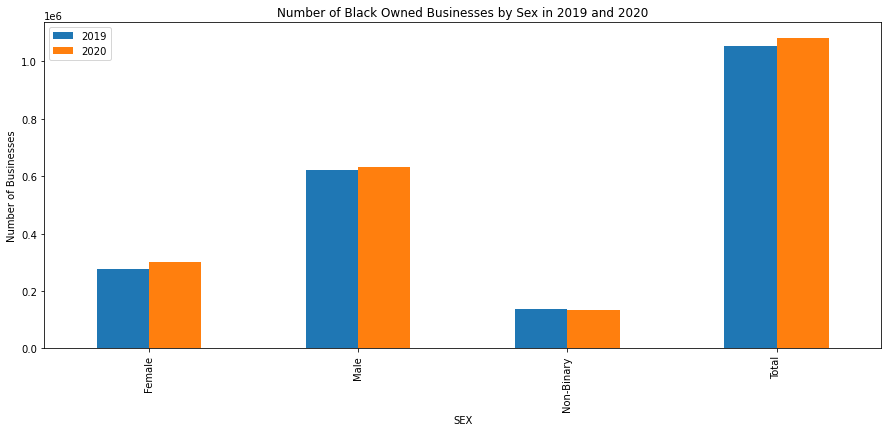

In [203]:
ax = black.plot(title = 'Number of Black Owned Businesses by Sex in 2019 and 2020', ylabel = 'Number of Businesses', y= ['FIRMPDEMP_2019', 'FIRMPDEMP_2020'], kind ='bar', use_index =True, figsize=(15, 6))
ax.legend(["2019", "2020"])

In [194]:
bfilter = statemerge[(statemerge['SEX'] == 'Total') & (statemerge['RACE_GROUP'] == '90') & (statemerge['VET_GROUP'] == '001') & (statemerge['ETH_GROUP']== '001')]

In [195]:
bbusinesslost = bfilter.groupby('NAME').sum('CHANGE').nsmallest(7, 'CHANGE')

Text(0.5, 1.0, 'States That Lost the Most Black Owned Businesses Between 2019 & 2020')

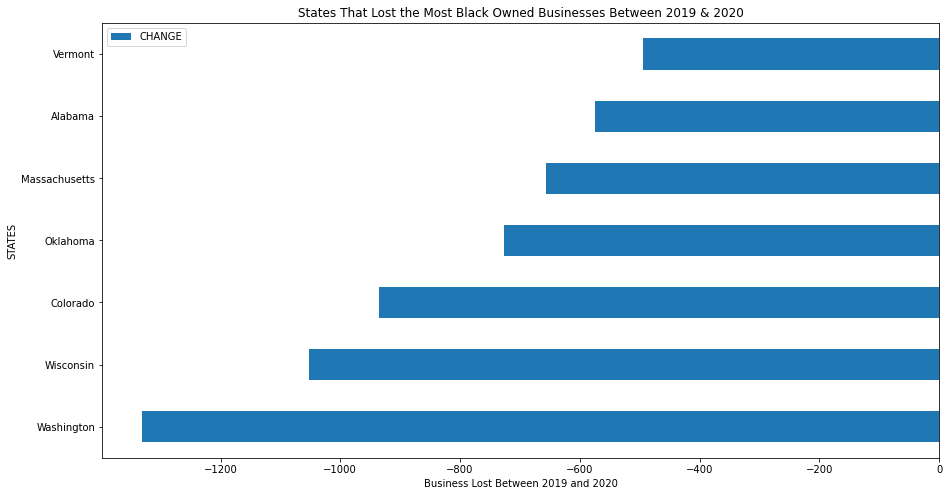

In [204]:
fig, ax = plt.subplots()
bbusinesslost.plot(kind='barh', ax=ax, y= 'CHANGE', figsize = (15,8))
ax.set_ylabel('STATES')
ax.set_xlabel('Business Lost Between 2019 and 2020')
ax.set_title('States That Lost the Most Black Owned Businesses Between 2019 & 2020')
#ax = df.plot(kind='bar') # "same" as above

In [205]:
bbusinessgained = bfilter.groupby('NAME').sum('CHANGE').nlargest(7, 'CHANGE')

Text(0.5, 1.0, 'States That Gained the Most Black Owned Businesses Between 2019 & 2020')

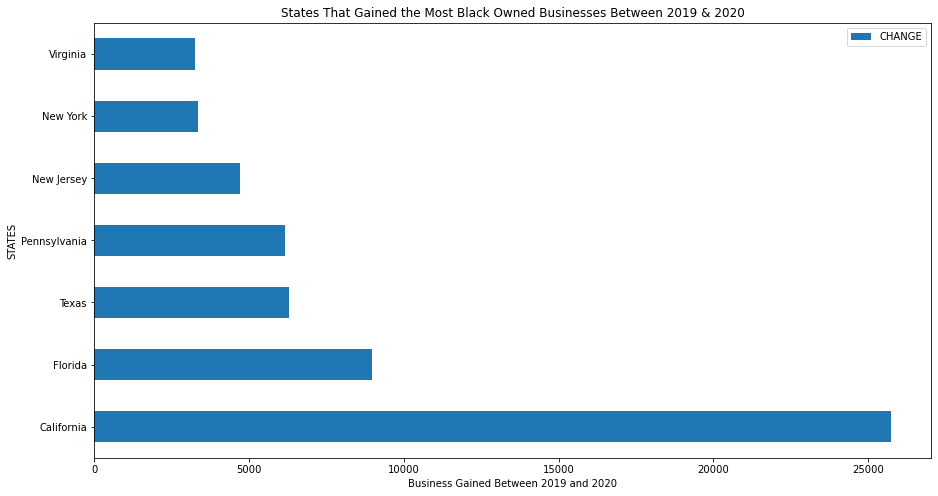

In [206]:
fig, ax = plt.subplots()
bbusinessgained.plot(kind='barh', ax=ax, y= 'CHANGE', figsize = (15,8))
ax.set_ylabel('STATES')
ax.set_xlabel('Business Gained Between 2019 and 2020')
ax.set_title('States That Gained the Most Black Owned Businesses Between 2019 & 2020')
#ax = df.plot(kind='bar') # "same" as above

In [207]:
sexfilter = statemerge[(statemerge['SEX'] != 'Non-Binary') & (statemerge['SEX'] != 'Total') & (statemerge['RACE_GROUP'] == '00') & (statemerge['VET_GROUP'] == '001') & (statemerge['ETH_GROUP']== '001')]

In [208]:
sexfilter

,NAME,SEX,ETH_GROUP,RACE_GROUP,VET_GROUP,FIRMPDEMP_2019,FIRMPDEMP_2020,CHANGE
4,Mississippi,Female,001,00,001,6659,7751,1092
5,Mississippi,Male,001,00,001,25943,24533,-1410
290,Missouri,Female,001,00,001,20311,23913,3602
306,Missouri,Male,001,00,001,59319,58367,-952
390,Montana,Female,001,00,001,5584,6079,495
...,...,...,...,...,...,...,...,...
8230,Iowa,Male,001,00,001,34277,33644,-633
8379,Maryland,Female,001,00,001,22668,23583,915
8529,Maryland,Male,001,00,001,63860,62230,-1630
8842,Texas,Female,001,00,001,84697,94432,9735


In [209]:
mf = sexfilter.groupby('SEX').sum('FIRMPDEMP_2019')

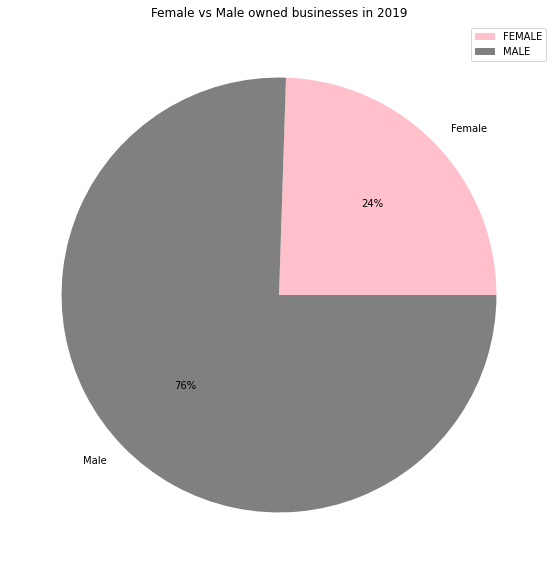

In [210]:
mf.plot.pie(title = 'Female vs Male owned businesses in 2019',y='FIRMPDEMP_2019', autopct='%1.0f%%', colors = ['pink', 'grey'], ylabel = '',figsize=(10,10)).legend(['FEMALE', 'MALE'])

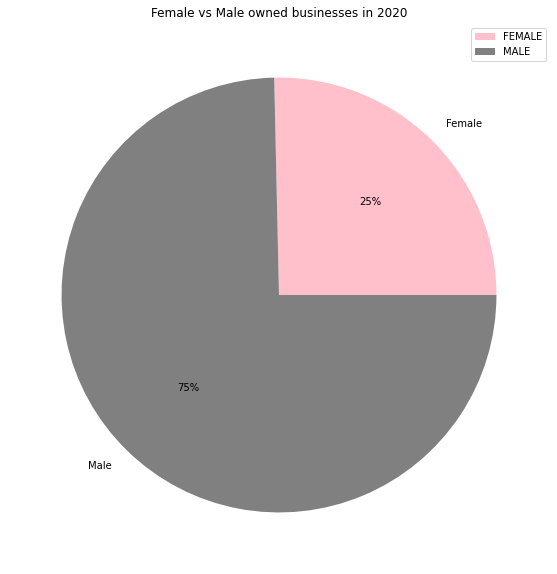

In [211]:
mf.plot.pie(title = 'Female vs Male owned businesses in 2020',y='FIRMPDEMP_2020', autopct='%1.0f%%', colors = ['pink', 'grey'], ylabel = '',figsize=(10,10)).legend(['FEMALE', 'MALE'])